<img src="crypto.jpg" />

In [1]:
import requests
import matplotlib
import numpy as np
import json
import snowflake.connector as sf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale


# retrieving data from database

In [2]:
conn = sf.connect(
    user='Vandalism',
    password='Rakovosel0123321',
    account='pv92401.europe-west4.gcp',
    warehouse='crypto1',
    database='api1',
    schema='eda1'
)
print("connected")
# Create a cursor object to execute SQL queries
cur = conn.cursor()
print("created cursor")


cur.execute("SELECT * FROM coins1 ORDER BY marketcap DESC")

df = pd.DataFrame(cur.fetchall(), columns= ['name','tags','marketcap'])
conn.close()
df

DatabaseError: 250001 (08001): Failed to connect to DB: pv92401.europe-west4.gcp.snowflakecomputing.com:443. Your free trial has ended and all of your virtual warehouses have been suspended. Add billing information in the Snowflake web UI to continue using the full set of Snowflake features.

# Attempting to clean & split dataframe

In [ ]:
pd.set_option('display.max_rows', 1000)

df['tags'] = df['tags'].astype(str)

# Split the values in the "tags" column
df['tags'] = df['tags'].str.split(',')



# Unpack the list of tags into individual rows, but keeping it in seperate dataframe
#it will create a row for each value
df1 = df.explode('tags')

#removing unnecessary symbols,

df1['tags'] = df1['tags'].str.replace('[','').str.replace(']', '').str.strip()
df1['tags'] = df1['tags'].str.replace('\\', '').str.strip()
df1['tags'] = df1['tags'].str.replace('[\'\"]', '', regex=True).str.strip()




#using regex to merge 2 strip calls 

# Count the distinct tags and their frequency from DF1
df1['tags'] = df1['tags'].replace(['bnb-chain', 'binance-smart-chain'], 'binance-chain')
df2=df1['tags'].value_counts().reset_index()
df1=df1.reset_index(drop=True)
df1.head(1000)

# count of distinct tags
# what are the most developed ecosystems and how many are there?
Cryptocurrency ecosystems refer to the interconnected network of platforms, technologies, communities, and projects that revolve around a particular cryptocurrency or blockchain. These ecosystems are designed to support various functionalities, including transactions, smart contracts, decentralized applications (dApps), and more.

In [ ]:
tag_counts = df1['tags'].value_counts().sort_values(ascending=False)
tag_counts


In [ ]:
df_filtered = df2[df2['tags'].str.contains('ecosystem|chain')]
# replace '-' characters in 'tags' column
df_filtered = df_filtered[~df_filtered['tags'].str.contains('portfolio|Portfolio|reef chain|sidechain|cross chain')]

# group by 'tags' column and sum 'count' column for duplicate rows
df_filtered = df_filtered.groupby('tags', as_index=False).sum()

distinct_tags_count = df_filtered['tags'].nunique()
print(f"Number of distinct ecosystems: {distinct_tags_count}")
df_filtered


# most developed ecosystems by count of coins

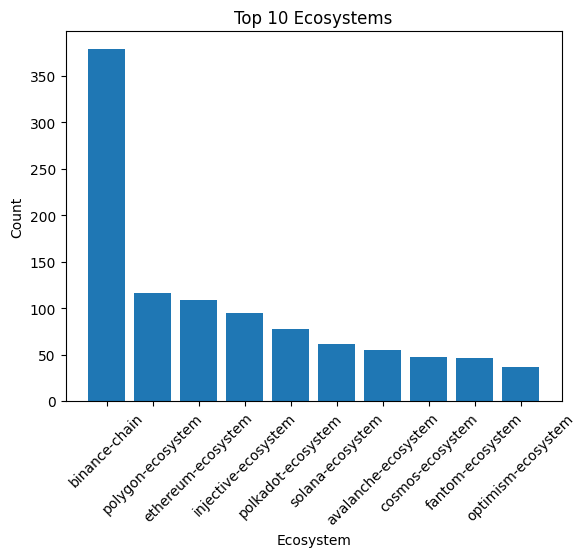

In [8]:
# select top 10 ecosystems and sort in descending order
top_ecosystems = df_filtered.sort_values('count', ascending=False).head(10)

# create bar chart
plt.bar(top_ecosystems['tags'], top_ecosystems['count'])

# add labels and title
plt.xlabel('Ecosystem')
plt.ylabel('Count')
plt.title('Top 10 Ecosystems')

# rotate x-axis labels for better readability
plt.xticks(rotation=45)

# show plot
plt.show()


# distribution of marketcap with and without Bitcoin & Ethereum
showing how really dominant in the field of cryptocurrency Bitcoin & Ethereum are in terms of market dominance

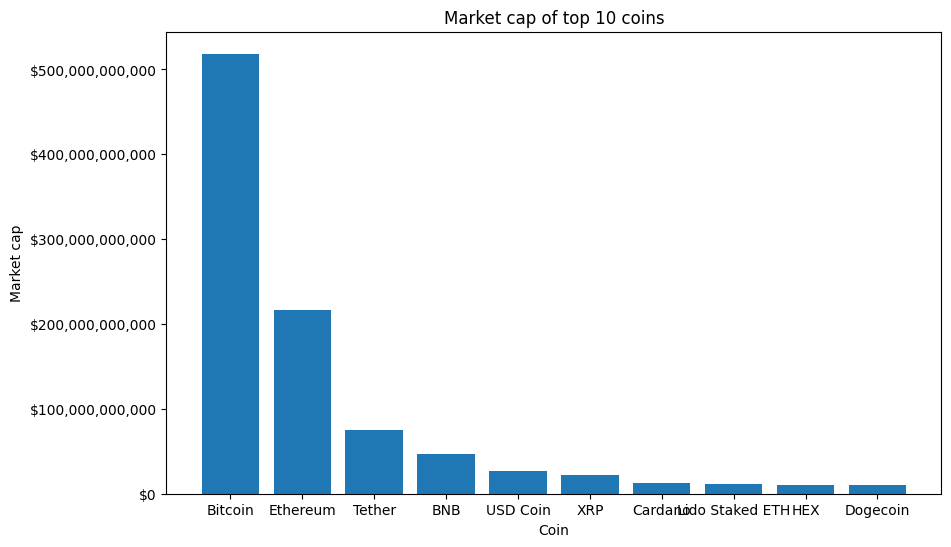

In [11]:
market_caps = df.iloc[:10]['marketcap'].values
coins = df.iloc[:10]['name'].values

# Create a bar chart with a larger size
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(coins, market_caps)

# Format the y-axis ticks as currency
formatter = '${x:,.0f}'
ax.yaxis.set_major_formatter(formatter)

# Set the title and axis labels
ax.set_title('Market cap of top 10 coins')
ax.set_xlabel('Coin')
ax.set_ylabel('Market cap')

# Show the plot
plt.show()

In [12]:
# Calculate the total market cap
total_marketcap = df['marketcap'].sum()
total_marketcap_excluding_first_two = '${:,.2f}'.format(df.iloc[2:]['marketcap'].sum())

# Initialize variables for market cap and percentage
marketcap = []
percentage = []

# Loop through different subsets
for i, n in [(10, '10'), (100, '100'), (1000, '1000')]:
    if len(df) > i:
        # Calculate market cap and percentage for subset
        marketcap.append('${:,.2f}'.format(df.iloc[:i]['marketcap'].sum()))
        percentage.append('{:.2%}'.format(df.iloc[:i]['marketcap'].sum() / total_marketcap))
        # Print results
        print(f"Market cap of top {n} coins:", marketcap[-1])
        print(f"Percentage of total market cap represented by top {n} coins:", percentage[-1])
        print('--------------------------------------------------------------------------')

# Loop through different subsets without BTC and ETH
for i, n in [(8, '8'), (98, '98'), (998, '998')]:
    if len(df) > i + 2:
        # Calculate market cap and percentage for subset without BTC and ETH
        marketcap.append('${:,.2f}'.format(df.iloc[2:i+2]['marketcap'].sum()))
        percentage.append('{:.2%}'.format(df.iloc[2:i+2]['marketcap'].sum() / total_marketcap))
        # Print results
        print(f"Market cap without btc & eth top {n}:", marketcap[-1])
        print(f"Percentage of total market cap represented without btc & eth (first {n}):", percentage[-1])
        print('--------------------------------------------------------------------------')

# Print total market cap
print('total market cap:', '${:,.2f}'.format(total_marketcap))
print("market cap without btc & etc:", total_marketcap_excluding_first_two)


Market cap of top 10 coins: $949,797,778,144.70
Percentage of total market cap represented by top 10 coins: 81.89%
--------------------------------------------------------------------------
Market cap of top 100 coins: $1,105,909,366,534.90
Percentage of total market cap represented by top 100 coins: 95.35%
--------------------------------------------------------------------------
Market cap of top 1000 coins: $1,158,564,645,448.30
Percentage of total market cap represented by top 1000 coins: 99.89%
--------------------------------------------------------------------------
Market cap without btc & eth top 8: $214,247,904,492.09
Percentage of total market cap represented without btc & eth (first 8): 18.47%
--------------------------------------------------------------------------
Market cap without btc & eth top 98: $370,359,492,882.29
Percentage of total market cap represented without btc & eth (first 98): 31.93%
-------------------------------------------------------------------------

# How many investors are there per coin, who do they invest in?
Venture capitalists in the cryptocurrency industry are specialized investors who fund and support startups and projects in the blockchain and cryptocurrency space. They possess deep knowledge of the market, evaluate projects based on various criteria, and provide financial investment, guidance, and connections. Venture capitalists play a crucial role in fueling innovation, fostering collaboration, and driving the growth of the cryptocurrency ecosystem. However, they also face risks due to market volatility and regulatory uncertainties. Overall, venture capitalists contribute to the development of the industry and shape the future of blockchain technology.

# labeling how many distinct portfolios per coin

In [40]:


# Filter the DataFrame to include only rows with "portfolio" in the tags column
portfolio_df = df1[df1["tags"].str.contains("portfolio")]

# Group the filtered DataFrame by the "name" column and count the number of rows
count_df = portfolio_df.groupby("name").size().reset_index(name="count")

# Merge the marketcap and count DataFrames on the "name" column
merged_df = pd.merge(count_df, portfolio_df[["name", "marketcap", "tags"]], on="name")

# Group the merged DataFrame by the "name" column and create a list of tags for each name
portfolio_tags = merged_df.groupby("name").agg({"count": "sum", "marketcap": "mean", "tags": lambda x: x.tolist()})


# Reset the index of the portfolio_tags DataFrame
portfolio_tags = portfolio_tags.reset_index()

portfolio_tags["count"] = portfolio_tags["count"].apply(np.sqrt)

portfolio_tags= portfolio_tags.drop(portfolio_tags[(portfolio_tags['name'] == 'Bitcoin') | (portfolio_tags['name'] == 'Ethereum')].index)

portfolio_tags


,name,count,marketcap,tags
0,0x Protocol,7.0,193915577.345578,"[polychain-capital-portfolio, blockchain-capit..."
1,1inch Network,5.0,341990206.894157,"[binance-labs-portfolio, blockchain-capital-po..."
2,API3,4.0,109635698.167538,"[coinfund-portfolio, dcg-portfolio, placeholde..."
3,APY.Finance,2.0,363898.084173,"[alameda-research-portfolio, exnetwork-capital..."
4,APYSwap,2.0,170532.243596,"[exnetwork-capital-portfolio, okex-blockdream-..."
5,ARPA,1.0,45386624.111263,[arrington-xrp-capital-portfolio]
6,Aave,6.0,962731214.206213,"[three-arrows-capital-portfolio, blockchain-ca..."
7,Acala Token,1.0,47841170.613326,[arrington-xrp-capital-portfolio]
8,AirSwap,1.0,17725152.717551,[kenetic-capital-portfolio]
9,Akropolis,3.0,17002618.074399,"[kenetic-capital-portfolio, ledgerprime-portfo..."


In [29]:
bins = [0, 2, 4, 8, portfolio_tags["count"].max()]

# Create labels for each bin
labels = ["1-2", "2-4", "5-8", "9-max"]

# Add a new column with the bin labels
portfolio_tags["count_label"] = pd.cut(portfolio_tags["count"], bins=bins, labels=labels)
portfolio_tags = portfolio_tags.sort_values("count", ascending=False)

# Print the updated DataFrame
portfolio_tags

,name,count,marketcap,tags,count_label
218,Oasis Network,11.0,315513614.568428,"[polychain-capital-portfolio, binance-labs-por...",9-max
206,Nervos Network,9.0,137167504.933257,"[polychain-capital-portfolio, blockchain-capit...",9-max
199,NEAR Protocol,8.0,1532163006.462543,"[coinbase-ventures-portfolio, three-arrows-cap...",5-8
335,Zcash,8.0,556202638.701699,"[boostvc-portfolio, dcg-portfolio, electric-ca...",5-8
321,Uniswap,8.0,2921522860.991583,"[coinbase-ventures-portfolio, three-arrows-cap...",5-8
69,Compound,8.0,277130990.456232,"[coinbase-ventures-portfolio, three-arrows-cap...",5-8
82,DODO,8.0,60186648.626085,"[coinbase-ventures-portfolio, three-arrows-cap...",5-8
114,Filecoin,8.0,2022211933.156349,"[polychain-capital-portfolio, blockchain-capit...",5-8
183,Maker,8.0,642473473.816621,"[polychain-capital-portfolio, dragonfly-capita...",5-8
155,Internet Computer,7.0,2381551787.28891,"[polychain-capital-portfolio, electric-capital...",5-8


# scatter plot has rather unusual results, it shows that number of investor portfolios don't have a correlation.

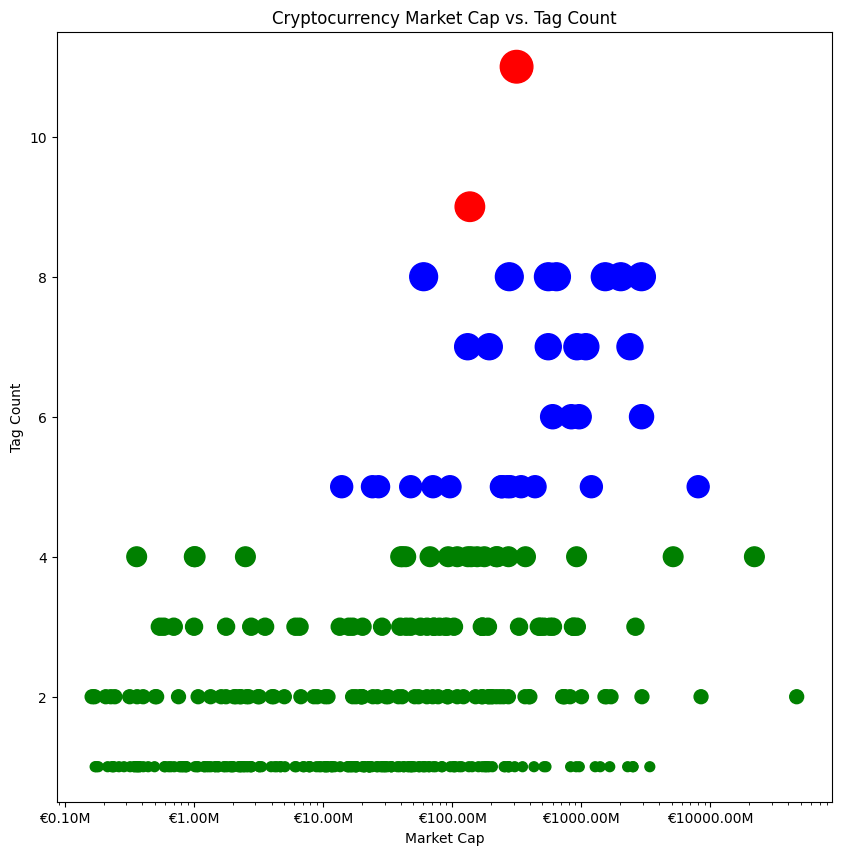

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels with the Euro symbol
def euro_formatter(x, pos):
    return '€{:.2f}M'.format(x/1000000)

fig, ax = plt.subplots(figsize=(10, 10))

# create scatter plot
sizes = portfolio_tags['count'] * 50
colors = portfolio_tags['count_label'].apply(lambda x: 'red' if x == '9-max' else 'blue' if x == '5-8' else 'green')
plt.scatter(portfolio_tags['marketcap'], portfolio_tags['count'], s=sizes, c=colors)

# set x-axis scale to log
plt.xscale('log')

# format tick labels on x-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(euro_formatter))

# set axis labels and title
plt.xlabel('Market Cap')
plt.ylabel('Tag Count')
plt.title('Cryptocurrency Market Cap vs. Tag Count')

# show plot
plt.show()



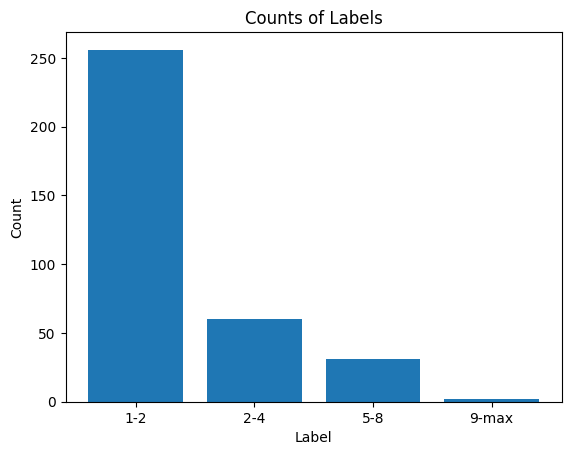

In [31]:
label_counts = {}
for label in labels:
    label_counts[label] = portfolio_tags[portfolio_tags['count_label'] == label]['name'].count()

# create a bar chart
fig, ax = plt.subplots()
ax.bar(label_counts.keys(), label_counts.values())

# set chart title and axis labels
ax.set_title('Counts of Labels')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

# display the chart
plt.show()

   # a lot of outliers

In [32]:
# set the locale to format numbers as Euro currency
locale.setlocale(locale.LC_ALL, 'de_DE')

# define the quantiles
low_quantile = 0.025
high_quantile = 0.975

# group the data by tag_bin
grouped = portfolio_tags.groupby('count_label')

# iterate over each group and find the outliers
for name, group in grouped:
    # calculate the lower and upper bounds based on quantiles
    low_bound = group['marketcap'].quantile(low_quantile)
    high_bound = group['marketcap'].quantile(high_quantile)

    # filter out the outliers
    outliers = group[(group['marketcap'] < low_bound) | (group['marketcap'] > high_bound)]

    # format the marketcap column as Euro currency
    outliers['marketcap'] = outliers['marketcap'].apply(lambda x: locale.currency(x, grouping=True))

    # print the results
    print(f"Outliers for {name}:\n{outliers.drop('tags', axis=1)}\n")



Outliers for 1-2:
                 name  count            marketcap count_label
32                BNB    2.0  46.502.940.203,16 €         1-2
234           Polygon    2.0   8.453.511.839,79 €         1-2
313     Tidal Finance    2.0         163.264,32 €         1-2
4             APYSwap    2.0         170.532,24 €         1-2
93           DinoSwap    2.0         208.203,73 €         1-2
318      UNUS SED LEO    2.0   2.948.488.122,31 €         1-2
295           Stellar    1.0   2.285.198.017,12 €         1-2
96        Dragon Kart    1.0         172.276,41 €         1-2
108  Ethereum Classic    1.0   2.510.594.476,15 €         1-2
113        Falconswap    1.0         182.200,36 €         1-2
67          Chainlink    1.0   3.391.742.720,55 €         1-2
205     Nerve Finance    1.0         215.278,26 €         1-2
214       OIN Finance    1.0         176.078,00 €         1-2
215               OKB    1.0   2.516.117.475,00 €         1-2

Outliers for 2-4:
                name  count      

C:\Users\penoslavija\AppData\Local\Temp\ipykernel_10736\885576105.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['marketcap'] = outliers['marketcap'].apply(lambda x: locale.currency(x, grouping=True))
C:\Users\penoslavija\AppData\Local\Temp\ipykernel_10736\885576105.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['marketcap'] = outliers['marketcap'].apply(lambda x: locale.currency(x, grouping=True))
C:\Users\penoslavija\AppData\Local\Temp\ipykernel_10736\885576105.py:23: Setting

# aggregating marketcap of coins in distinct portfolio

In [41]:
# explode the tags column
exploded_df = portfolio_tags.explode("tags")

# group by the tags column and sum the marketcap and count the names
portfolio = exploded_df.groupby("tags").agg({"marketcap": "sum", "name": "count"}).reset_index()

# rename the 'name' column to 'count'
portfolio.rename(columns={"name": "count"}, inplace=True)

# print the resulting dataframe
portfolio





,tags,marketcap,count
0,1confirmation-portfolio,4332034672.260045,6
1,a16z-portfolio,32174844161.701412,17
2,alameda-research-portfolio,70038845047.848969,51
3,animoca-brands-portfolio,5162478223.058574,40
4,arrington-xrp-capital-portfolio,30148077072.054459,31
5,binance-labs-portfolio,15679270634.999231,28
6,blockchain-capital-portfolio,8864202510.857731,15
7,boostvc-portfolio,7616207088.487218,12
8,circle-ventures-portfolio,3418155377.388229,6
9,cms-holdings-portfolio,14753880780.075788,17


# Visualization

exnetwork has the biggest number of investments but their investments lay around less funded projects while okex-blockdream has twice as less but invests in more established projects

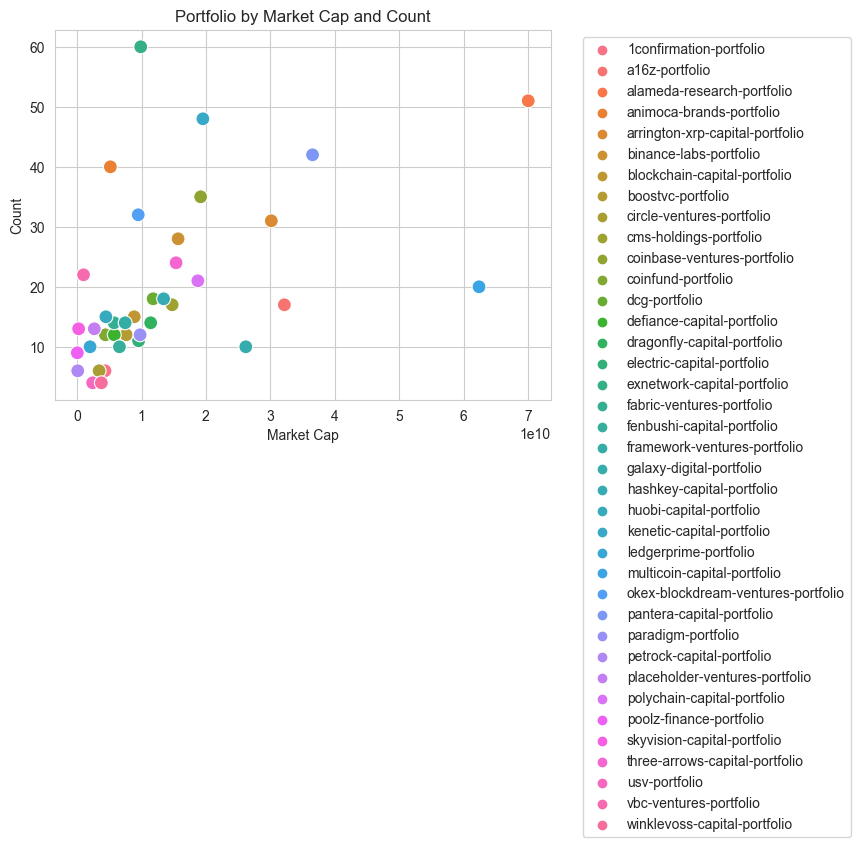

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# create the scatter plot
sns.scatterplot(data=portfolio, x="marketcap", y="count", hue="tags", s=100)

# set the title and axis labels
plt.title("Portfolio by Market Cap and Count")
plt.xlabel("Market Cap")
plt.ylabel("Count")

# move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# display the plot
plt.show()



